# White Player Win Predictions

[vinamrata-git](https://github.com/vinamrata-git)

In [2]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 28 kB/s 


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':100})

In [4]:
url = "https://raw.githubusercontent.com/vinamrata-git/Chess-winner-prediction/main/games.csv"
df = pd.read_csv(url)

In [5]:
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [6]:
df.shape

(20058, 16)

In [7]:
df.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

In [8]:
df.dtypes

id                 object
rated                bool
created_at        float64
last_move_at      float64
turns               int64
victory_status     object
winner             object
increment_code     object
white_id           object
white_rating        int64
black_id           object
black_rating        int64
moves              object
opening_eco        object
opening_name       object
opening_ply         int64
dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [10]:
df.isnull().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

In [11]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,20058,19113,XRuQPSzH,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rated,20058,2,True,16155,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_at,20058,NaN,NaN,NaN,1.48362e+12,2.85015e+10,1.37677e+12,1.47755e+12,1.49601e+12,1.50317e+12,1.50449e+12
last_move_at,20058,NaN,NaN,NaN,1.48362e+12,2.85014e+10,1.37677e+12,1.47755e+12,1.49601e+12,1.50317e+12,1.50449e+12
turns,20058,NaN,NaN,NaN,60.466,33.5706,1,37,55,79,349
victory_status,20058,4,resign,11147,NaN,NaN,NaN,NaN,NaN,NaN,NaN
winner,20058,3,white,10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
increment_code,20058,400,10+0,7721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
white_id,20058,9438,taranga,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
white_rating,20058,NaN,NaN,NaN,1596.63,291.253,784,1398,1567,1793,2700


## Cleaning

In [12]:
df['difference'] = df['created_at'] - df['last_move_at']
df['difference']

0             0.0
1             0.0
2             0.0
3             0.0
4             0.0
           ...   
20053   -321734.0
20054   -744219.0
20055   -172834.0
20056   -946699.0
20057   -736699.0
Name: difference, Length: 20058, dtype: float64

In [13]:
df = df.drop(['created_at', 'last_move_at'], axis=1)

In [14]:
df = df.drop(['increment_code', 'white_id', 'black_id', 'difference'], axis=1)

In [15]:
df.head()

,id,rated,turns,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,13,outoftime,white,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,16,resign,black,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,61,mate,white,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,61,mate,white,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,95,mate,white,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Moves

In [16]:
moves = df.moves.str.split(n=2, expand=True)
moves

,0,1,2
0,d4,d5,c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4
1,d4,Nc6,e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6 Qe5+ N...
2,e4,e5,d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc6 bxc6...
3,d4,d5,Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O-O O-O...
4,e4,e5,Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 Nf6 Bg5...
...,...,...,...
20053,d4,f5,e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5 d6 Bh...
20054,d4,d6,Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd3 O-O ...
20055,d4,d5,Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd2 b6 N...
20056,e4,d6,d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb6 c5 N...


In [17]:
df['white_1move'] = moves[0]
df['black_1move'] = moves[1]

In [18]:
df_wm = pd.crosstab(df.white_1move, columns=df.winner, normalize='index')
df_wm.head()

winner,black,draw,white
white_1move,,,
Na3,0.750000,0.000000,0.250000
Nc3,0.555556,0.020202,0.424242
Nf3,0.402759,0.082759,0.514483
Nh3,0.400000,0.000000,0.600000
a3,0.333333,0.037037,0.629630


In [19]:
dict(df_wm['white'])
df['white_1move'] = df['white_1move'].map(dict(df_wm['white']))

In [20]:
df_bm = pd.crosstab(df.black_1move, columns=df.winner, normalize='index')
df_bm.head()

winner,black,draw,white
black_1move,,,
Na6,0.000000,0.000000,1.000000
Nc6,0.382653,0.053571,0.563776
Nf6,0.486119,0.062611,0.451270
Nh6,0.166667,0.000000,0.833333
a5,0.260870,0.130435,0.608696


In [21]:
dict(df_bm['white'])
df['black_1move'] = df['black_1move'].map(dict(df_bm['white']))

In [22]:
df_ = pd.crosstab(df.opening_eco, columns = df.winner, normalize='index')
df_

winner,black,draw,white
opening_eco,,,
A00,0.566038,0.038729,0.395233
A01,0.487805,0.048780,0.463415
A02,0.548780,0.060976,0.390244
A03,0.487179,0.128205,0.384615
A04,0.354386,0.098246,0.547368
...,...,...,...
E92,0.200000,0.600000,0.200000
E94,0.500000,0.000000,0.500000
E95,0.000000,0.000000,1.000000


In [23]:
dict(df_['white'])

{'A00': 0.3952333664349553,
 'A01': 0.4634146341463415,
 'A02': 0.3902439024390244,
 'A03': 0.38461538461538464,
 'A04': 0.5473684210526316,
 'A05': 0.5625,
 'A06': 0.472,
 'A07': 0.5151515151515151,
 'A08': 0.46153846153846156,
 'A09': 0.5294117647058824,
 'A10': 0.5354330708661418,
 'A11': 0.5,
 'A12': 0.0,
 'A13': 0.7346938775510204,
 'A14': 0.0,
 'A15': 0.5333333333333333,
 'A16': 0.48,
 'A17': 0.5,
 'A18': 0.6666666666666666,
 'A20': 0.54,
 'A21': 0.5396825396825397,
 'A22': 0.4642857142857143,
 'A23': 1.0,
 'A24': 0.0,
 'A25': 0.7272727272727273,
 'A27': 0.5454545454545454,
 'A28': 0.5,
 'A29': 0.75,
 'A30': 0.5833333333333334,
 'A31': 0.0,
 'A33': 0.0,
 'A34': 0.5909090909090909,
 'A35': 0.6923076923076923,
 'A36': 0.75,
 'A38': 0.5714285714285714,
 'A39': 0.6666666666666666,
 'A40': 0.5469255663430421,
 'A41': 0.6,
 'A42': 0.47619047619047616,
 'A43': 0.47435897435897434,
 'A44': 0.7142857142857143,
 'A45': 0.40476190476190477,
 'A46': 0.34177215189873417,
 'A47': 0.25,
 'A48':

In [24]:
df['opening_eco'] = df['opening_eco'].map(dict(df_['white']))

In [25]:
df.head()

,id,rated,turns,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,white_1move,black_1move
0,TZJHLljE,False,13,outoftime,white,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,0.400000,Slav Defense: Exchange Variation,5,0.499337,0.493591
1,l1NXvwaE,True,16,resign,black,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,0.597381,Nimzowitsch Defense: Kennedy Variation,4,0.499337,0.563776
2,mIICvQHh,True,61,mate,white,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,0.442963,King's Pawn Game: Leonardis Variation,3,0.505715,0.515312
3,kWKvrqYL,True,61,mate,white,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,0.511521,Queen's Pawn Game: Zukertort Variation,3,0.499337,0.493591
4,9tXo1AUZ,True,95,mate,white,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,0.573082,Philidor Defense,5,0.505715,0.515312


In [26]:
df.white_1move.nunique()

20

In [27]:
df.black_1move.nunique()

20

In [28]:
df.isnull().sum()

id                 0
rated              0
turns              0
victory_status     0
winner             0
white_rating       0
black_rating       0
moves              0
opening_eco        0
opening_name       0
opening_ply        0
white_1move        0
black_1move       18
dtype: int64

In [29]:
df.dropna().head()

,id,rated,turns,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,white_1move,black_1move
0,TZJHLljE,False,13,outoftime,white,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,0.400000,Slav Defense: Exchange Variation,5,0.499337,0.493591
1,l1NXvwaE,True,16,resign,black,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,0.597381,Nimzowitsch Defense: Kennedy Variation,4,0.499337,0.563776
2,mIICvQHh,True,61,mate,white,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,0.442963,King's Pawn Game: Leonardis Variation,3,0.505715,0.515312
3,kWKvrqYL,True,61,mate,white,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,0.511521,Queen's Pawn Game: Zukertort Variation,3,0.499337,0.493591
4,9tXo1AUZ,True,95,mate,white,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,0.573082,Philidor Defense,5,0.505715,0.515312


In [30]:
df.moves.unique()

array(['d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4',
       'd4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6 Qe5+ Nxe5 c4 Bb4+',
       'e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc6 bxc6 Ra6 Nc4 a4 c3 a3 Nxa3 Rxa3 Rxa3 c4 dxc4 d5 cxd5 Qxd5 exd5 Be6 Ra8+ Ke7 Bc5+ Kf6 Bxf8 Kg6 Bxg7 Kxg7 dxe6 Kh6 exf7 Nf6 Rxh8 Nh5 Bxh5 Kg5 Rxh7 Kf5 Qf3+ Ke6 Bg4+ Kd6 Rh6+ Kc5 Qe3+ Kb5 c4+ Kb4 Qc3+ Ka4 Bd1#',
       ...,
       'd4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd2 b6 Ne5 Nxe5 Bxe5 Nd7 Bxh7+ Kxh7 Qh5+ Kg8 Nf3 f6 Bf4 g5 Qg6+ Kh8 Nh4 Qe8 Qh6+ Kg8 Ng6 Kf7 Qh7#',
       'e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb6 c5 Nd5 Bc4 e6 Bxd5 exd5 Nc3 d4 Ne4 Bf5 f3 Nd7 b4 Nxe5 Bf4 f6 g4 Bxe4 fxe4 c6 Bxe5 fxe5 Nf3 Be7 Nxe5 Bf6 Nc4 O-O-O h4 h6 e5 b5 cxb6 Be7 bxa7 Kc7 a3 Rhf8 Kd2 Rf4 Rag1 d3 h5 Rf2+ Ke3 Re2+ Kf4 Rf8+ Kg3 Re3+ Nxe3 d2 Rd1 Bg5 Nf5 Kb7 Rhf1 Kxa7 Nd6 Rxf1 Rxf1 Kb6 e6 Kc7 Nf5 Kc8 e7 Kd7 a4 Bxe7 Nxe7 Kxe7 a5 Kd7 Rd1 Kc7 Rxd2 Kb7 Ra2 Ka6 Kf4 Kb5 a6 Kb6 a7 Kb5 a8=Q Kxb4 Qxc6 g5+ hxg6 Kb3 Rc

In [31]:
df.opening_ply.nunique()

23

In [32]:
df.opening_name.nunique()

1477

## Categorical variables

In [33]:
df['rated'].unique()

array([False,  True])

In [34]:
df.victory_status.unique()

array(['outoftime', 'resign', 'mate', 'draw'], dtype=object)

In [35]:
df.drop(columns = ['opening_name', 'id', 'victory_status', 'turns', 'moves'], axis=1, inplace=True)

In [36]:
df.head()

,rated,winner,white_rating,black_rating,opening_eco,opening_ply,white_1move,black_1move
0,False,white,1500,1191,0.400000,5,0.499337,0.493591
1,True,black,1322,1261,0.597381,4,0.499337,0.563776
2,True,white,1496,1500,0.442963,3,0.505715,0.515312
3,True,white,1439,1454,0.511521,3,0.499337,0.493591
4,True,white,1523,1469,0.573082,5,0.505715,0.515312


In [37]:
df.replace({False: 0, True: 1}, inplace=True)

In [38]:
df.head()

,rated,winner,white_rating,black_rating,opening_eco,opening_ply,white_1move,black_1move
0,0,white,1500,1191,0.400000,5,0.499337,0.493591
1,1,black,1322,1261,0.597381,4,0.499337,0.563776
2,1,white,1496,1500,0.442963,3,0.505715,0.515312
3,1,white,1439,1454,0.511521,3,0.499337,0.493591
4,1,white,1523,1469,0.573082,5,0.505715,0.515312


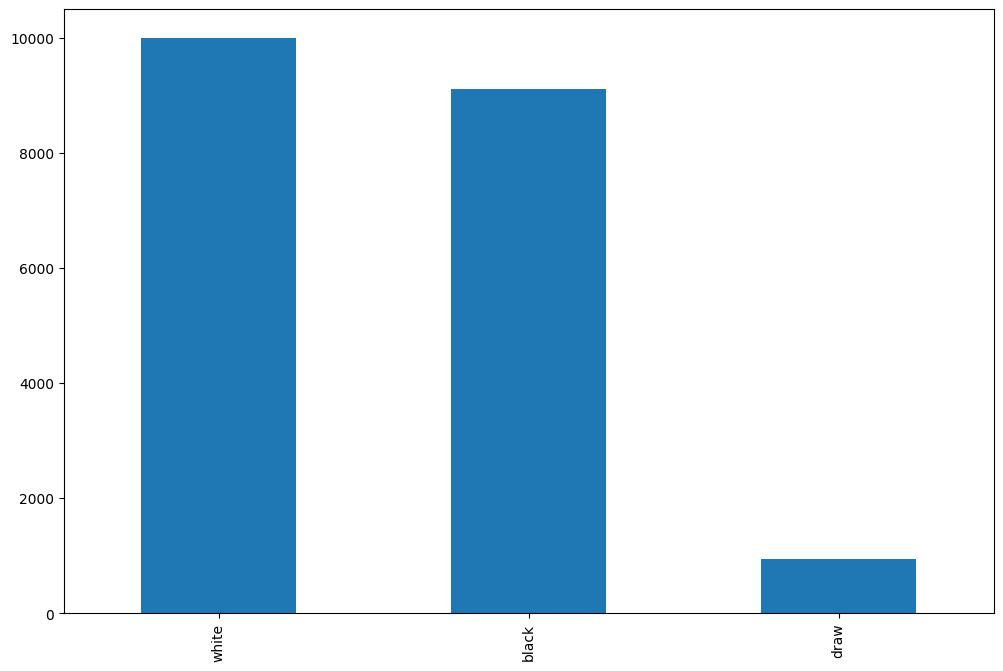

In [39]:
df.winner.value_counts().plot(kind='bar')

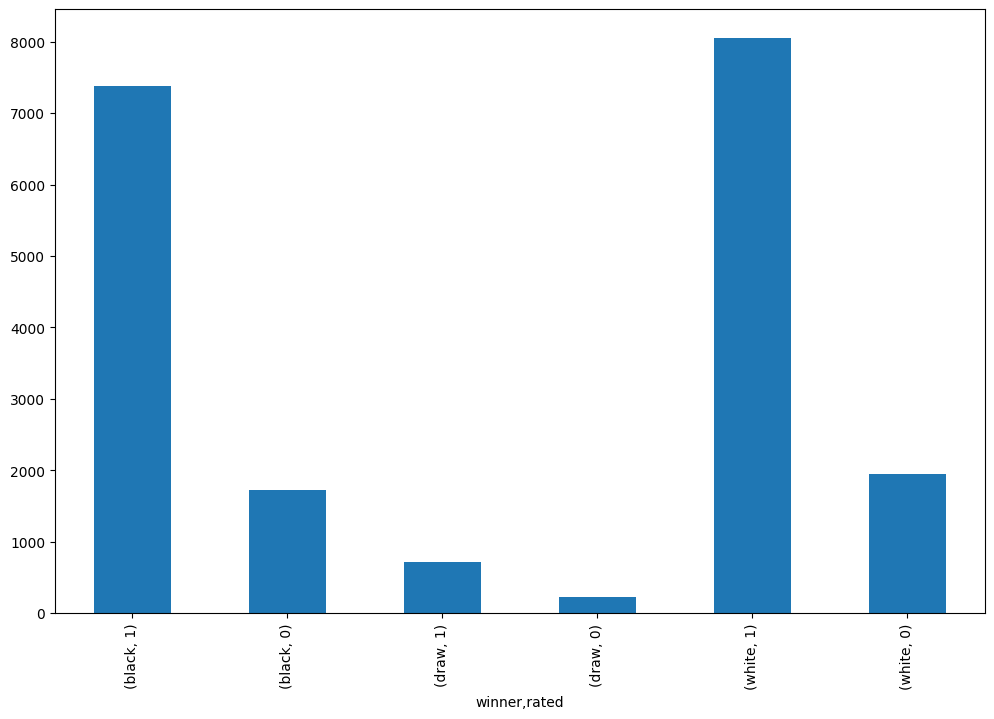

In [40]:
df.groupby('winner').rated.value_counts().plot(kind='bar')

In [41]:
df = df.dropna().copy()

In [42]:
df.to_csv("data_cleaned")

## Features and Target

In [43]:
X = df.drop('winner', axis=1)
X

,rated,white_rating,black_rating,opening_eco,opening_ply,white_1move,black_1move
0,0,1500,1191,0.400000,5,0.499337,0.493591
1,1,1322,1261,0.597381,4,0.499337,0.563776
2,1,1496,1500,0.442963,3,0.505715,0.515312
3,1,1439,1454,0.511521,3,0.499337,0.493591
4,1,1523,1469,0.573082,5,0.505715,0.515312
...,...,...,...,...,...,...,...
20053,1,1691,1220,0.527273,2,0.499337,0.506024
20054,1,1233,1196,0.600000,2,0.499337,0.561694
20055,1,1219,1286,0.461434,3,0.499337,0.493591
20056,1,1360,1227,0.555921,4,0.505715,0.561694


In [44]:
y = df.winner

In [45]:
y

0        white
1        black
2        white
3        white
4        white
         ...  
20053    white
20054    black
20055    white
20056    white
20057    black
Name: winner, Length: 20040, dtype: object

## Train Test Split

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

## Feature Scaling

In [48]:
from sklearn.preprocessing import StandardScaler

In [49]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [50]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Building

### Model 1: Logistic Regression

In [51]:
model1 = LogisticRegression(class_weight = 'balanced', max_iter = 1e5)
model1.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100000.0, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [52]:
y_pred1 = model1.predict(X_test_scaled)

In [74]:
print(accuracy_score(y_test, y_pred1))
print(precision_score(y_test, y_pred1, average='weighted'))
print(recall_score(y_test, y_pred1, average='weighted'))
prob_1 = model1.predict_proba(X_test_scaled)

0.532435129740519
0.6352413679181765
0.532435129740519


In [63]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

       black       0.66      0.51      0.58      1821
        draw       0.08      0.35      0.12       190
       white       0.67      0.57      0.61      1997

    accuracy                           0.53      4008
   macro avg       0.47      0.48      0.44      4008
weighted avg       0.64      0.53      0.57      4008



### Model 2: KNN

In [113]:
def classification_model(models):
  model = models
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)
  
  print(accuracy_score(y_test, y_pred))
  print(precision_score(y_test, y_pred, average='weighted'))
  print(recall_score(y_test, y_pred, average='weighted'))
  prob = model.predict_proba(X_test_scaled)

  print(classification_report(y_test, y_pred))
  return model, y_pred, prob

In [114]:
model2, y_pred2, prob_2 = classification_model(KNeighborsClassifier(2))

0.5421656686626747
0.5700859908432121
0.5421656686626747
              precision    recall  f1-score   support

       black       0.52      0.76      0.62      1821
        draw       0.12      0.12      0.12       190
       white       0.66      0.38      0.48      1997

    accuracy                           0.54      4008
   macro avg       0.43      0.42      0.41      4008
weighted avg       0.57      0.54      0.53      4008



### Model 3: Gaussian

In [115]:
model3, y_pred3, prob_3 = classification_model(GaussianNB())

0.5865768463073853
0.5863736293222751
0.5865768463073853
              precision    recall  f1-score   support

       black       0.65      0.37      0.47      1821
        draw       0.11      0.03      0.05       190
       white       0.57      0.84      0.68      1997

    accuracy                           0.59      4008
   macro avg       0.44      0.41      0.40      4008
weighted avg       0.59      0.59      0.56      4008



### Model 4: Support Vector Machine

In [116]:
model4, y_pred4, prob_4 = classification_model(SVC(probability=True))

0.6387225548902196
0.6091035706859208
0.6387225548902196


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       black       0.64      0.58      0.61      1821
        draw       0.00      0.00      0.00       190
       white       0.63      0.76      0.69      1997

    accuracy                           0.64      4008
   macro avg       0.43      0.44      0.43      4008
weighted avg       0.61      0.64      0.62      4008



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 5: Decision Tree

In [117]:
model5, y_pred5, prob_5 = classification_model(DecisionTreeClassifier())

0.5778443113772455
0.580110546303177
0.5778443113772455
              precision    recall  f1-score   support

       black       0.58      0.57      0.58      1821
        draw       0.15      0.17      0.16       190
       white       0.62      0.62      0.62      1997

    accuracy                           0.58      4008
   macro avg       0.45      0.45      0.45      4008
weighted avg       0.58      0.58      0.58      4008



### Model 6: Random Forest Classifier

In [118]:
model6, y_pred6, prob_6 = classification_model(RandomForestClassifier(class_weight='balanced'))

0.6359780439121756
0.6321666129621943
0.6359780439121756
              precision    recall  f1-score   support

       black       0.62      0.62      0.62      1821
        draw       0.55      0.12      0.20       190
       white       0.65      0.70      0.67      1997

    accuracy                           0.64      4008
   macro avg       0.61      0.48      0.50      4008
weighted avg       0.63      0.64      0.63      4008



### Model 7: AdaBoost

In [119]:
model7, y_pred7, prob_7 = classification_model(AdaBoostClassifier())

0.6299900199600799
0.6015463797649243
0.6299900199600799
              precision    recall  f1-score   support

       black       0.64      0.56      0.60      1821
        draw       0.00      0.00      0.00       190
       white       0.62      0.75      0.68      1997

    accuracy                           0.63      4008
   macro avg       0.42      0.44      0.43      4008
weighted avg       0.60      0.63      0.61      4008



### Model 8: XGBoost

In [120]:
model8, y_pred8, prob_8 = classification_model(XGBClassifier())

0.6347305389221557
0.604142980627914
0.6347305389221557
              precision    recall  f1-score   support

       black       0.63      0.61      0.62      1821
        draw       0.00      0.00      0.00       190
       white       0.64      0.72      0.68      1997

    accuracy                           0.63      4008
   macro avg       0.42      0.44      0.43      4008
weighted avg       0.60      0.63      0.62      4008



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 9: LGBM

In [121]:
model9, y_pred9, prob_9 = classification_model(LGBMClassifier())

0.6372255489021956
0.6406986031107117
0.6372255489021956
              precision    recall  f1-score   support

       black       0.63      0.61      0.62      1821
        draw       0.73      0.04      0.08       190
       white       0.64      0.72      0.68      1997

    accuracy                           0.64      4008
   macro avg       0.67      0.46      0.46      4008
weighted avg       0.64      0.64      0.62      4008



### Model 10: CatBoost

In [122]:
model10, y_pred10, prob_10 = classification_model(CatBoostClassifier())

Learning rate set to 0.091154
0:	learn: 1.0556118	total: 10.4ms	remaining: 10.4s
1:	learn: 1.0209798	total: 20ms	remaining: 9.96s
2:	learn: 0.9916765	total: 29.7ms	remaining: 9.88s
3:	learn: 0.9652201	total: 39.2ms	remaining: 9.76s
4:	learn: 0.9416436	total: 49.1ms	remaining: 9.76s
5:	learn: 0.9217090	total: 58.6ms	remaining: 9.71s
6:	learn: 0.9041655	total: 68.4ms	remaining: 9.7s
7:	learn: 0.8888193	total: 77.9ms	remaining: 9.66s
8:	learn: 0.8753360	total: 87.9ms	remaining: 9.68s
9:	learn: 0.8624015	total: 97.7ms	remaining: 9.67s
10:	learn: 0.8515163	total: 107ms	remaining: 9.64s
11:	learn: 0.8425491	total: 117ms	remaining: 9.63s
12:	learn: 0.8344414	total: 127ms	remaining: 9.62s
13:	learn: 0.8269163	total: 137ms	remaining: 9.64s
14:	learn: 0.8195184	total: 150ms	remaining: 9.86s
15:	learn: 0.8133649	total: 161ms	remaining: 9.88s
16:	learn: 0.8078656	total: 171ms	remaining: 9.89s
17:	learn: 0.8029500	total: 181ms	remaining: 9.86s
18:	learn: 0.7986529	total: 191ms	remaining: 9.84s
19:	

## Model Comparison

In [129]:
a, p, r, f = [], [], [], []
for model in [model1, model2, model3, model4, model5, model6, model7, model8, model9, model10]:
  a.append(accuracy_score(y_test, model.predict(X_test_scaled)))
  p.append(precision_score(y_test, model.predict(X_test_scaled), average='weighted'))
  r.append(recall_score(y_test, model.predict(X_test_scaled), average='weighted'))
  f.append(f1_score(y_test, model.predict(X_test_scaled), average='weighted'))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
model_score = pd.DataFrame([a, p, r, f],
                           columns = ['LR', 'KNN', 'Gaussian', 'SVM', 'DT', 
                                      'RF', 'AdaB', 'XGB', 'LGBM', 'CatB'])\
                                      .T.sort_values(by=3, ascending=False)\
                                      .rename(columns={0:'Accuracy', 1:'Precision',
                                                       2:'Recall', 3:'F1'}).round(4)

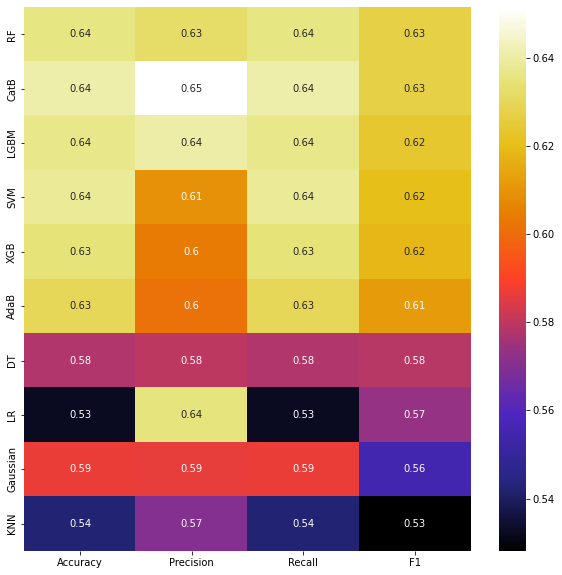

In [133]:
plt.figure(figsize=(10,10))
sns.heatmap(model_score, annot=True, cmap='CMRmap')
plt.show()

## AUC-ROC Curve

In [134]:
from sklearn.metrics import roc_curve

In [135]:
fpr1, tpr1, thresh1 = roc_curve(y_test, prob_1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, prob_2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, prob_3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, prob_4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, prob_5[:,1], pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(y_test, prob_6[:,1], pos_label=1)
fpr7, tpr7, thresh7 = roc_curve(y_test, prob_7[:,1], pos_label=1)
fpr8, tpr8, thresh8 = roc_curve(y_test, prob_8[:,1], pos_label=1)
fpr9, tpr9, thresh9 = roc_curve(y_test, prob_9[:,1], pos_label=1)
fpr10, tpr10, thresh10 = roc_curve(y_test, prob_10[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [136]:
from sklearn.metrics import roc_auc_score

In [151]:
import matplotlib.pyplot as plt
plt.style.use('fast')

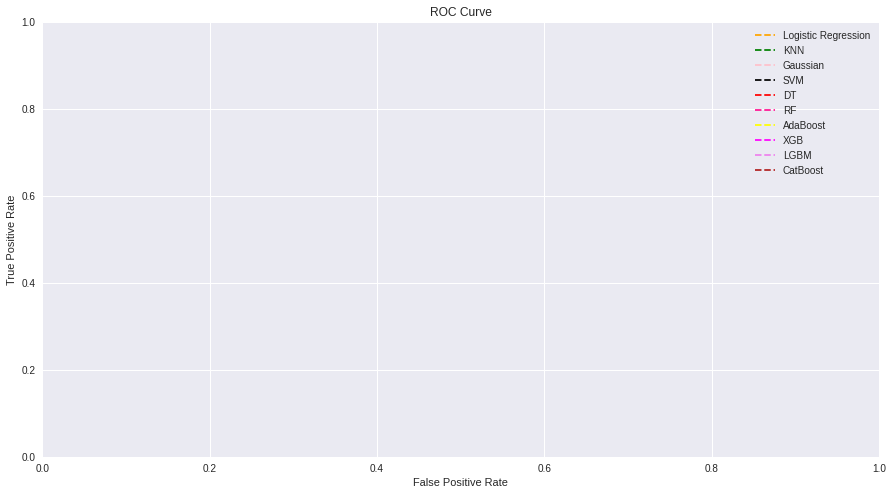

In [152]:
plt.figure(figsize=(15,8))

plt.plot(fpr1, tpr1, linestyle='--', color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--', color='green', label='KNN')
plt.plot(fpr3, tpr3, linestyle='--', color='pink', label='Gaussian')
plt.plot(fpr4, tpr4, linestyle='--', color='black', label='SVM')
plt.plot(fpr5, tpr5, linestyle='--', color='red', label='DT')
plt.plot(fpr6, tpr6, linestyle='--', color='deeppink', label='RF')
plt.plot(fpr7, tpr7, linestyle='--', color='yellow', label='AdaBoost')
plt.plot(fpr8, tpr8, linestyle='--', color='magenta', label='XGB')
plt.plot(fpr9, tpr9, linestyle='--', color='violet', label='LGBM')
plt.plot(fpr10, tpr10, linestyle='--', color='firebrick', label='CatBoost')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.savefig("ROC", dpi=300)
plt.show()